# Mount the Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import Packages

In [0]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.ticker as tkr
import seaborn as sns
sns.set()

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import random as rn
import os
from tensorflow.keras import optimizers,backend as K
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation,BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

# Function Defintion

In [0]:
def MLP_data_prep(df,use_mean=True):
  df=df.drop(columns=['Adj Close','SMA_15','SMA_30','Upper_Bollinger','Lower_Bollinger','Middle_Bollinger','holiday_day_diff_before'])
  df=rescaling(df,df.drop(['bullish','median_sentiment_score','mean_sentiment_score','std_sentiment_score','max_sentiment_score','min_sentiment_score'],1).columns.tolist(),scale_type='MinMax')
  df['std_sentiment_score']=impute_missing_value_sentiment(df['std_sentiment_score'].tolist())
  df['max_sentiment_score']=impute_missing_value_sentiment(df['max_sentiment_score'].tolist())
  df['min_sentiment_score']=impute_missing_value_sentiment(df['min_sentiment_score'].tolist())
  if use_mean:
    df=df.drop(columns=['median_sentiment_score'])
    df['mean_sentiment_score']=impute_missing_value_sentiment(df['mean_sentiment_score'].tolist())
    col=['mean_sentiment_score','std_sentiment_score','max_sentiment_score','min_sentiment_score']
  else:
    df=df.drop(columns=['mean_sentiment_score'])
    df['median_sentiment_score']=impute_missing_value_sentiment(df['median_sentiment_score'].tolist())
    col=['median_sentiment_score','std_sentiment_score','max_sentiment_score','min_sentiment_score']
  
  # for sent in col:
  #   sentiment=df[sent].tolist()
  #   for i in range(9):
  #     sentiment.pop()
  #     sentiment.insert(0,np.nan)
  #     df[sent+'_before_'+str(i+1)]=sentiment
  df=df[~(pd.isnull(df.bullish) | pd.isnull(df.close_diff_last_9_hour))]
  df=df.reset_index(drop=True)
  return(df)

def rescaling(df,columns,scale_type='Standard'):
  '''
  Function for Feature Scaling
  '''
  scale_type=scale_type.lower()
  scaled_X=df.drop(columns,1)
  X=df[columns]
  
  if scale_type=='minmax':
    scaler=MinMaxScaler(feature_range=(0,1))
  elif scale_type=='standard':
    scaler=StandardScaler()

  scaled_column=scaler.fit_transform(X)
  scaled_column=pd.DataFrame(scaled_column,columns=columns)
  for column in columns:
    scaled_X[column]=scaled_column[column].tolist()
  return(scaled_X)

def impute_missing_value_sentiment(col:list):
  it=range(len(col))
  for i in it:
    if pd.isnull(col[i]):
      if i==1:
        col[i]=col[i+1]
      else:
        col[i]=col[i-1]
  if any(pd.isnull(col)):
    col=impute_missing_value_sentiment(col)
  else:
    return col

# Import Data

In [0]:
link ='https://drive.google.com/open?id=1Zpy6dTBCdZmcWwByQjCM1He8DzSe8Ynr'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_final.csv')  
df = pd.read_csv('df_final.csv')
df=df.drop('Unnamed: 0',1)
df_mean_sentiment=MLP_data_prep(df,use_mean=True)
df_median_sentiment=MLP_data_prep(df,use_mean=False)

1Zpy6dTBCdZmcWwByQjCM1He8DzSe8Ynr


In [0]:
df_mean_sentiment

,bullish,mean_sentiment_score,std_sentiment_score,max_sentiment_score,min_sentiment_score,Open,High,Low,Close,Volume,volume_before_1,volume_diff_last_hour,volume_before_2,volume_diff_last_2_hour,volume_before_3,volume_diff_last_3_hour,volume_before_4,volume_diff_last_4_hour,volume_before_5,volume_diff_last_5_hour,close_before_1,close_diff_last_hour,close_before_2,close_diff_last_2_hour,close_before_3,close_diff_last_3_hour,close_before_4,close_diff_last_4_hour,close_before_5,close_diff_last_5_hour,close_before_6,close_diff_last_6_hour,close_before_7,close_diff_last_7_hour,close_before_8,close_diff_last_8_hour,close_before_9,close_diff_last_9_hour,SMA_indicator,SMA_indicator_before_1,SMA_indicator_before_2,SMA_indicator_before_3,SMA_indicator_before_4,close_diff_Upper_Bollinger,close_diff_Lower_Bollinger,Bollinger_indicator,Bollinger_indicator_before_1,Bollinger_indicator_before_2,Bollinger_indicator_before_3,Bollinger_indicator_before_4,true_range,date,weekday,time
0,1.0,0.438550,0.137926,0.438550,0.438550,0.024106,0.020713,0.011953,0.009592,0.030566,0.051459,0.380675,0.058972,0.367764,0.086786,0.424565,0.025290,0.385258,0.025598,0.389890,0.024655,0.640556,0.005321,0.573415,0.015662,0.411326,0.097647,0.648016,0.075015,0.580875,0.082059,0.570011,0.093906,0.661122,0.065481,0.580324,0.072769,0.632084,0.0,0.0,0.0,0.0,0.0,0.659593,0.328701,0.666667,0.666667,0.666667,1.000000,0.333333,0.065160,0.066667,0.75,0.500000
1,1.0,0.049601,0.009227,0.056125,0.043076,0.008159,0.005035,0.007079,0.012065,0.029148,0.030566,0.372166,0.051459,0.380675,0.058972,0.367764,0.086786,0.424565,0.025290,0.385258,0.009592,0.562733,0.024655,0.640556,0.005321,0.573415,0.015662,0.411326,0.097647,0.648016,0.075015,0.580875,0.082059,0.570011,0.093906,0.661122,0.065481,0.580324,0.0,0.0,0.0,0.0,0.0,0.667602,0.344539,0.666667,0.666667,0.666667,0.666667,1.000000,0.039615,0.066667,0.75,0.666667
2,1.0,0.029437,0.072489,0.080695,-0.021820,0.011571,0.004938,0.001992,0.001199,0.037558,0.029148,0.384552,0.030566,0.372166,0.051459,0.380675,0.058972,0.367764,0.086786,0.424565,0.012065,0.602408,0.009592,0.562733,0.024655,0.640556,0.005321,0.573415,0.015662,0.411326,0.097647,0.648016,0.075015,0.580875,0.082059,0.570011,0.093906,0.661122,0.0,0.0,0.0,0.0,0.0,0.651771,0.334478,0.666667,0.666667,0.666667,0.666667,0.666667,0.051333,0.066667,0.75,0.833333
3,1.0,0.064746,0.146437,0.201572,-0.148232,0.000000,0.000000,0.005488,0.000000,0.053051,0.037558,0.390802,0.029148,0.384552,0.030566,0.372166,0.051459,0.380675,0.058972,0.367764,0.001199,0.572228,0.012065,0.602408,0.009592,0.562733,0.024655,0.640556,0.005321,0.573415,0.015662,0.411326,0.097647,0.648016,0.075015,0.580875,0.082059,0.570011,0.0,0.0,0.0,0.0,0.0,0.652787,0.342657,0.666667,0.666667,0.666667,0.666667,0.666667,0.031471,0.066667,0.75,1.000000
4,1.0,0.167817,0.154938,0.438971,-0.345884,0.040906,0.068158,0.050218,0.077896,0.057706,0.053051,0.395308,0.037558,0.390802,0.029148,0.384552,0.030566,0.372166,0.051459,0.380675,0.000000,0.594100,0.001199,0.572228,0.012065,0.602408,0.009592,0.562733,0.024655,0.640556,0.005321,0.573415,0.015662,0.411326,0.097647,0.648016,0.075015,0.580875,0.0,0.0,0.0,0.0,0.0,0.779741,0.507545,0.333333,0.666667,0.666667,0.666667,0.666667,0.180293,0.100000,1.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,0.0,0.187055,0.198835,0.422218,-0.209867,0.151345,0.144489,0.159074,0.149014,0.017740,0.020379,0.385385,0.020488,0.375683,0.035851,0.346267,0.097464,0.419429,0.044044,0.398252,0.153627,0.582909,0.159772,0.583061,0.165851,0.588354,0.169589,0.656494,0.143211,0.595287,0.143885,0.592744,0.145683,0.593759,0.147033,0.592236,0.149056,0.583250,0.0,0.0,0.0,1.0,1.0,0.753197,0.327259,0.666667,0.666667,0.666667,0.666667,0.666667,0.011655,0.866667,1.00,0.666667
1729,0.0,0.152675,0.172927,0.420582,-0.296020,0.147233,0.145312,0.156

# Hyperparameter Tuning

#Train Samples:  163 #Val Samples:  157


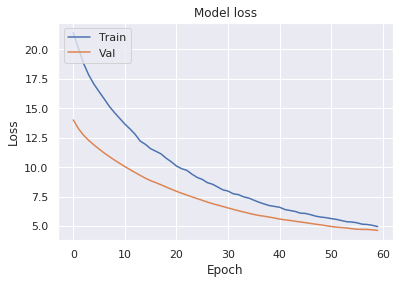



#Train Samples:  320 #Val Samples:  157


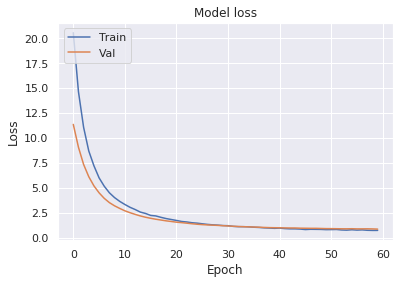



#Train Samples:  477 #Val Samples:  157


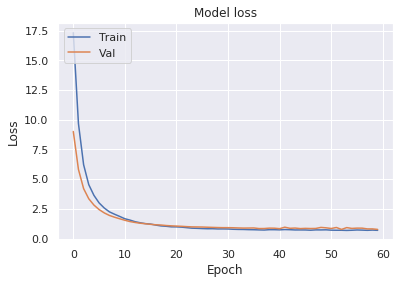



#Train Samples:  634 #Val Samples:  157


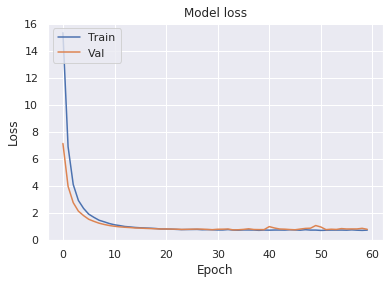



#Train Samples:  791 #Val Samples:  157


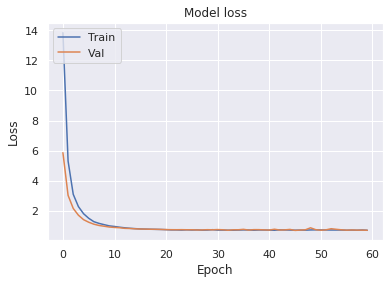



#Train Samples:  948 #Val Samples:  157


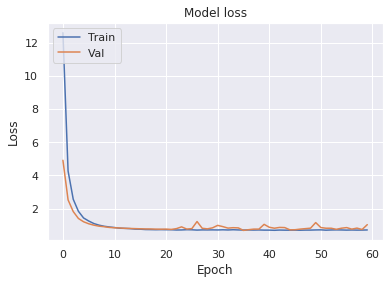



#Train Samples:  1105 #Val Samples:  157


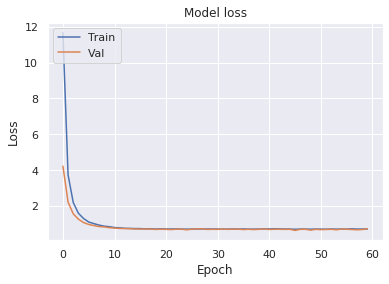



#Train Samples:  1262 #Val Samples:  157


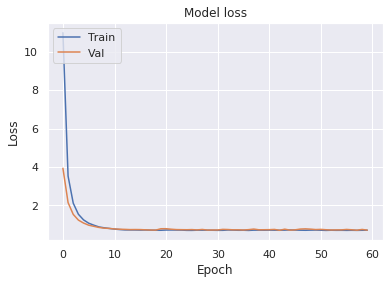



#Train Samples:  1419 #Val Samples:  157


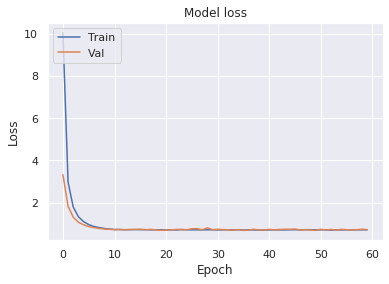



#Train Samples:  1576 #Val Samples:  157


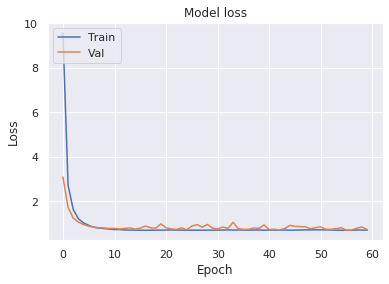



Epochs: 60
Hidden Nodes 1: 128
Input Dropout Rate: 0.2
Hidden Dropout Rate: 0.2
Activation Function: relu
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f1af8a3da58>



,0,1,2,3,4,5,6,7,8,9,AC_mean,AC_std
0.552,0.528662,0.566879,0.656051,0.535032,0.560510,0.452229,0.566879,0.585987,0.503185,0.624204,0.557962,0.055249
0.551,0.528662,0.566879,0.656051,0.522293,0.560510,0.452229,0.566879,0.585987,0.503185,0.617834,0.556051,0.055165
0.550,0.528662,0.566879,0.656051,0.515924,0.560510,0.452229,0.566879,0.585987,0.496815,0.617834,0.554777,0.056214
0.547,0.528662,0.573248,0.662420,0.509554,0.560510,0.445860,0.554140,0.560510,0.496815,0.617834,0.550955,0.058116
0.549,0.528662,0.573248,0.656051,0.503185,0.560510,0.445860,0.560510,0.566879,0.496815,0.617834,0.550955,0.057625
...,...,...,...,...,...,...,...,...,...,...,...,...
0.453,0.528662,0.554140,0.445860,0.566879,0.547771,0.433121,0.585987,0.445860,0.522293,0.312102,0.494268,0.079819
0.455,0.528662,0.554140,0.445860,0.566879,0.547771,0.433121,0.585987,0.452229,0.515924,0.312102,0.494268,0.079258
0.450,0.528662,0.554140,0.439490,0.566879,0.547771,0.433121,0.585987,0.445860,0.522293,0.312102,0.493631,0.080227
0.452,0.528662,0.554140,0.445860,0.566879,0.547771,0.433121,0.585987,0.445860,0.515924,0.312102,0.493631,0.079618


In [0]:
threshold_lst=np.arange(0,1,0.001)
n_fold=10
hidden_nodes_1=128
input_dropout=0.2
hidden_dropout=0.2
l2_regularizer=0.06
act='relu'
optimizer=optimizers.Adam(learning_rate=0.001)
batch_size=32
epochs=60

X=df_mean_sentiment.drop('bullish',1)
y=df_mean_sentiment['bullish']


tscv = TimeSeriesSplit(n_splits=n_fold)
metrics_list = []
for train_index, val_index in tscv.split(X):
  print("#Train Samples: ", len(train_index), "#Val Samples: ", len(val_index))
  X_train, X_val = X.loc[train_index,:], X.loc[val_index,:]
  y_train, y_val = y[train_index], y[val_index]

  #Define MLP
  model = Sequential()
  model.add(Dropout(input_dropout, input_shape=(X_train.shape[1],)))
  model.add(Dense(hidden_nodes_1,kernel_initializer='glorot_normal',bias_initializer='glorot_normal',kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
  model.add(Activation(act))
  model.add(BatchNormalization())
  model.add(Dropout(hidden_dropout))
  model.add(Dense(hidden_nodes_1/2,kernel_initializer='glorot_normal',bias_initializer='glorot_normal',kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
  model.add(Activation(act))
  model.add(BatchNormalization())
  model.add(Dropout(hidden_dropout))
  model.add(Dense(hidden_nodes_1/4,kernel_initializer='glorot_normal',bias_initializer='glorot_normal',kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
  model.add(Activation(act))
  model.add(BatchNormalization())
  model.add(Dropout(hidden_dropout))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy']) 

  history=model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=False,
                  validation_data=(X_val, y_val))
  
  prediction_prob=model.predict_proba(X_val,batch_size=batch_size)
  prediction_prob=pd.Series(prediction_prob.tolist()).apply(lambda x: x[0])

  for k in threshold_lst :
    prediction=prediction_prob.apply(lambda x: 1 if x>k else 0)
    confusion=confusion_matrix(y_val,prediction)
    acc=(confusion[0][0]+confusion[1][1])/(confusion[0][0]+confusion[0][1]+confusion[1][0]+confusion[1][1])
    metrics_list.append(acc)

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
  print('')
  print('')
  # # Plot training & validation accuracy values
  # plt.plot(history.history['acc'])
  # plt.plot(history.history['val_acc'])
  # plt.title('Model accuracy')
  # plt.ylabel('Accuracy')
  # plt.xlabel('Epoch')
  # plt.legend(['Train', 'Val'], loc='upper left')
  # plt.show()

metrics_result = pd.DataFrame(np.array(metrics_list).reshape(n_fold,len(threshold_lst)).transpose())
metrics_result.index = threshold_lst
metrics_result['AC_mean'] = metrics_result.mean(axis=1)
metrics_result['AC_std']=metrics_result.std(axis=1)

print('Epochs: {}'.format(epochs))
print('Hidden Nodes 1: {}'.format(hidden_nodes_1))
# print('Hidden Nodes 2: {}'.format(hidden_nodes_2))
# print('Hidden Nodes 3: {}'.format(hidden_nodes_3))
print('Input Dropout Rate: {}'.format(input_dropout))
print('Hidden Dropout Rate: {}'.format(hidden_dropout))
print('Activation Function: {}'.format(act))
print('Optimizer: {}'.format(optimizer))
print('')

metrics_result.sort_values(by='AC_mean',ascending=False)